# Tutorial: Learning Bifurcating PDE Solutions with Physics-Informed Deep Ensembles

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mathLab/PINA/blob/master/tutorials/tutorial14/tutorial.ipynb)

This tutorial demonstrates how to use the Deep Ensemble Physics Informed Network (DeepEnsemblePINN) to learn PDEs exhibiting bifurcating behavior, as discussed in [*Learning and Discovering Multiple Solutions Using Physics-Informed Neural Networks with Random Initialization and Deep Ensemble*](https://arxiv.org/abs/2503.06320).

Let’s begin by importing the necessary libraries.

In [ ]:
## routine needed to run the notebook on Google Colab
try:
    import google.colab

    IN_COLAB = True
except:
    IN_COLAB = False
if IN_COLAB:
    !pip install "pina-mathlab[tutorial]"

import torch
import matplotlib.pyplot as plt
import warnings

from lightning.pytorch.callbacks import Callback

from pina import Trainer, Condition, LabelTensor
from pina.solver import DeepEnsemblePINN
from pina.model import FeedForward
from pina.operator import laplacian
from pina.problem import TimeDependentProblem
from pina.domain import CartesianDomain
from pina.equation import Equation
from pina.optim import TorchOptimizer

warnings.filterwarnings("ignore")

## Deep Ensemble

Deep Ensemble methods improve model performance by leveraging the diversity of predictions generated by multiple neural networks trained on the same problem. Each network in the ensemble is trained independently—typically with different weight initializations or even slight variations in the architecture or data sampling. By combining their outputs (e.g., via averaging or majority voting), ensembles reduce overfitting, increase robustness, and improve generalization.

This approach allows the ensemble to capture different perspectives of the problem, leading to more accurate and reliable predictions.

<p align="center">
    <img src="../static/deep_ensemble.png" alt="PINA Workflow" width="600"/>
</p>

The image above illustrates a Deep Ensemble setup, where multiple models attempt to predict the text from an image. While individual models may make errors (e.g., predicting "PONY" instead of "PINA"), combining their outputs—such as taking the majority vote—often leads to the correct result. This ensemble effect improves reliability by mitigating the impact of individual model biases.


## Deep Ensemble Physics-Informed Networks

In the context of Physics-Informed Neural Networks (PINNs), Deep Ensembles help the network discover different branches or multiple solutions of a PDE that exhibits bifurcating behavior.

By training a diverse set of models with different initializations, Deep Ensemble methods overcome the limitations of single-initialization models, which may converge to only one of the possible solutions. This approach is particularly useful when the solution space of the problem contains multiple valid physical states or behaviors.


## The Bratu Problem

In this tutorial, we'll train a `DeepEnsemblePINN` solver to solve a bifurcating ODE known as the **Bratu problem**. The ODE is given by:

$$
\frac{d^2u}{dt^2} + \lambda e^u = 0, \quad t \in (0, 1)
$$

with boundary conditions:

$$
u(0) = u(1) = 0,
$$

where $\lambda > 0$ is a scalar parameter. The analytical solutions to the 1D Bratu problem can be expressed as:

$$
u(t, \alpha) = 2 \log\left(\frac{\cosh(\alpha)}{\cosh(\alpha(1 - 2t))}\right),
$$

where $\alpha$ satisfies:

$$
\cosh(\alpha) - 2\sqrt{2}\alpha = 0.
$$

When $\lambda < 3.513830719$, the equation admits two solutions $\alpha_1$ and $\alpha_2$, which correspond to two distinct solutions of the original ODE: $u_1$ and $u_2$.

In this tutorial, we set $\lambda = 1$, which leads to:

- $\alpha_1 \approx 0.37929$
- $\alpha_2 \approx 2.73468$

We first write the problem class, we do not write the boundary conditions as we will hard impose them.

> **👉 We have a dedicated [tutorial](https://mathlab.github.io/PINA/tutorial16/tutorial.html) to teach how to build a Problem — have a look if you're interested!**

> **👉 We have a dedicated [tutorial](https://mathlab.github.io/PINA/tutorial3/tutorial.html) to teach how to impose hard constraints — have a look if you're interested!**

In [80]:
# define bratu equation
def bratu_eq(input_, output_):
    u_tt = laplacian(output_=output_, input_=input_, components=["u"], d=["t"])
    return u_tt + torch.exp(output_)

# define true solution
def true_solution(x):
    alpha1 = torch.tensor([0.37929])
    alpha2 = torch.tensor([2.73468])
    u1 = 2 * torch.log(torch.cosh(alpha1) / torch.cosh(alpha1 * (1 - 2 * x)))
    u2 = 2 * torch.log(torch.cosh(alpha2) / torch.cosh(alpha2 * (1 - 2 * x)))
    return u1, u2

# build problem class
class BratuProblem(TimeDependentProblem):
    output_variables = ["u"]
    temporal_domain = CartesianDomain({"t": [0, 1]})
    domains = {
        "interior": CartesianDomain({"t": [0, 1]}),
    }
    conditions = {
        "interior": Condition(domain="interior", equation=Equation(bratu_eq))
    }

# define problem and discretise domain
problem = BratuProblem()
problem.discretise_domain(n=101, mode="grid", domains="interior")

## Defining the Deep Ensemble Models

Now that the problem setup is complete, we move on to creating an **ensemble of models**. Each ensemble member will be a standard `FeedForward` neural network, wrapped inside a custom `Model` class.

Each model's weights are initialized using a **normal distribution** with mean 0 and standard deviation 2. This random initialization is crucial to promote diversity across the ensemble members, allowing the models to converge to potentially different solutions of the PDE.

The final ensemble is simply a **list of PyTorch models**, which we will later pass to the `DeepEnsemblePINN`

In [81]:
# define a single model (ensemble member)
class Model(torch.nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__()
        self.model = FeedForward(*args, **kwargs)
        self.init_weights_gaussian()

    def forward(self, x):
        return x * (1 - x) * self.model(x)

    def init_weights_gaussian(self):
        for param in self.model.parameters():
            if param.requires_grad:
                torch.nn.init.normal_(param, mean=0.0, std=2.0)

# define a list of models with different initializations
models = [Model(1, 1, inner_size=50, n_layers=2) for _ in range(10)]

Let's visualize the networks output before strated training

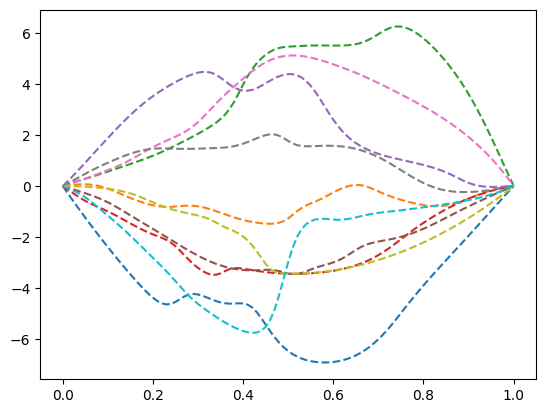

In [82]:
# plot solution
with torch.no_grad():
    pts = problem.input_pts["interior"]
    for model in models:
        plt.plot(pts, model(pts), "--")
    plt.plot()

As you can see we get different output since the neural networks are initialized differently.

## Training with `DeepEnsemblePINN`

Now that everything is ready, we can train the models using the `DeepEnsemblePINN` solver! 🎯

This solver is constructed by combining multiple neural network models that all aim to solve the same PDE. Each model $\mathcal{M}_{i \in \{1, \dots, 10\}}$ in the ensemble contributes a unique perspective due to different random initializations.

This diversity allows the ensemble to **capture multiple branches or bifurcating solutions** of the problem, making it especially powerful for PDEs like the Bratu problem.

Once the `DeepEnsemblePINN` solver is defined with all the models, we train them using the `Trainer` class, as with any other solver in **PINA**. We also build a callback to store the value of `u(0.5)` during training iterations.

In [83]:
# define the optimizers, one per model
optimizers = [TorchOptimizer(torch.optim.Adam, lr=0.006) for _ in range(10)]

# define solver
solver = DeepEnsemblePINN(
    problem,
    models,
    optimizers=optimizers,
)

# callback
class StoreValue(Callback):
    def on_train_epoch_start(self, trainer, pl_module):
        input = LabelTensor(torch.tensor([[0.5]]), 't')
        output = pl_module(input).tensor.flatten()
        if trainer.current_epoch == 0:
            self.store = [output]
        else:
            self.store.append(output)

# define trainer
trainer = Trainer(
    solver,
    max_epochs=500,
    accelerator="cpu",
    enable_model_summary=False,
    callbacks=[StoreValue()],
)

# train
trainer.train()

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=500` reached.


The training finished, let's first plot how the value of $u(0.5)$ changed during training

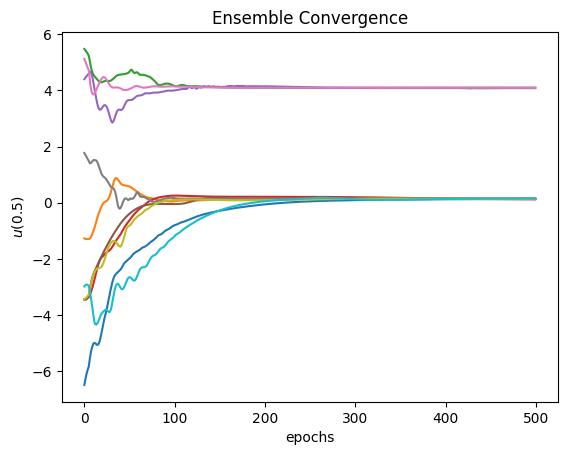

In [84]:
with torch.no_grad():
    metrics = torch.stack(trainer.callbacks[0].store, dim=0)
    plt.plot(range(metrics.shape[0]), metrics)
    plt.title('Ensemble Convergence')
    plt.ylabel(r'$u(0.5)$')
    plt.xlabel('epochs')
    plt.plot()

As you can see, different networks in the ensemble converge to different values pf $u(0.5)$ — this means we can actually **spot the bifurcation** in the solution space!

This is a powerful demonstration of how **Deep Ensemble Physics-Informed Neural Networks** are capable of learning **multiple valid solutions** of a PDE that exhibits bifurcating behavior.

We can also visualize the ensemble predictions to better observe the multiple branches:


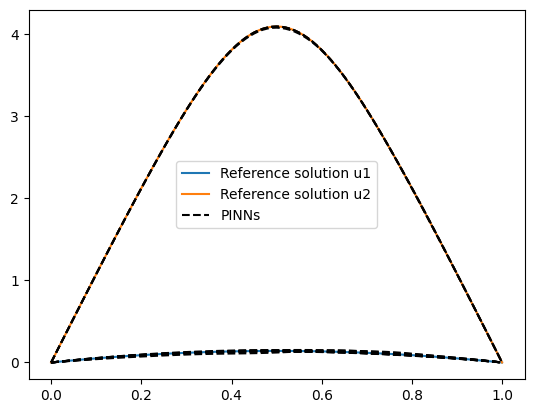

In [88]:
# plot solution
with torch.no_grad():
    pts = problem.input_pts["interior"]
    u_ensemble = solver(pts)
    u1, u2 = true_solution(pts)
    plt.plot(pts, u1, label="Reference solution u1")
    plt.plot(pts, u2, label="Reference solution u2")
    for idx, sol in enumerate(u_ensemble):
        if idx == 0:
            plt.plot(pts, sol, "--", label="PINNs", c='k')
        else:
            plt.plot(pts, sol, "--", c="k")
    plt.legend()
    plt.plot()
    plt.show()

## What's Next?

You have completed the tutorial on deep ensemble PINNs for bifurcating PDEs, well don! There are many potential next steps you can explore:

1. **Train the network longer or with different hyperparameters**: Experiment with different configurations of the single model, you can compose an ensemble by also stacking models with different layers, activation, ... to improve accuracy.

2. **Solve more complex problems**: The original paper provides very complex problems that can be solved with PINA, we suggest you to try implement and solve them!

3. **...and many more!**: There are countless directions to further explore, for example, what does it happen when you vary the network initialization hyperparameters?

For more resources and tutorials, check out the [PINA Documentation](https://mathlab.github.io/PINA/).